In [15]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('../utils')
import models
from scipy.stats import norm

sns.set(style="whitegrid")

In [16]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [17]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [18]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [19]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [20]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [21]:
df = pd.read_csv('../datasets/airbnb_selected_variables.csv', index_col=0)

Freeman Diaconis:  11


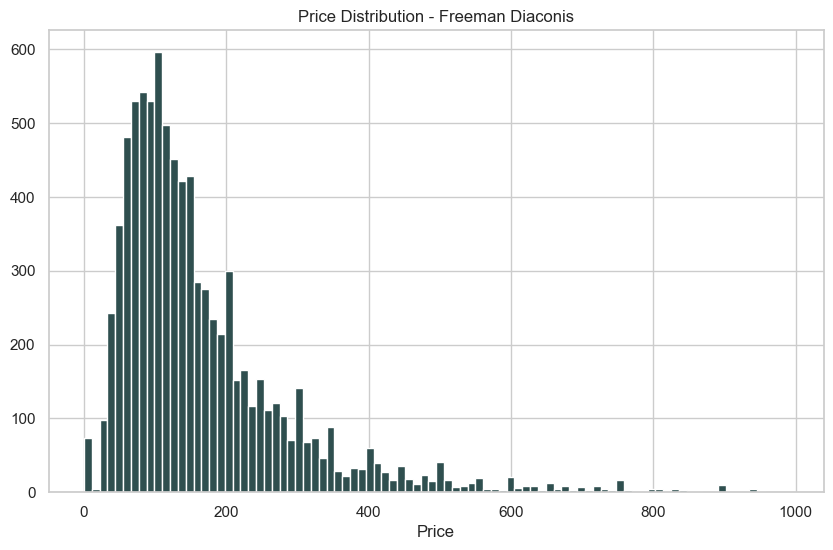

In [22]:
h = freeman_diaconis(df.price)
print("Freeman Diaconis: ", h)
mn = int(df.price.min())
mx = int(df.price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price,bins=bins, color="darkslategray")
axes.set_title("Price Distribution - Freeman Diaconis")
axes.set_xlabel("Price")

plt.show()
plt.close()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8628 entries, 0 to 8627
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 8628 non-null   float64
 1   bedrooms              8628 non-null   int64  
 2   beds                  8628 non-null   int64  
 3   accommodates          8628 non-null   int64  
 4   host_is_superhost     8628 non-null   object 
 5   host_response_time    8628 non-null   object 
 6   room_type             8628 non-null   object 
 7   property_type         8628 non-null   object 
 8   instant_bookable      8628 non-null   object 
 9   host_response_rate    8628 non-null   float64
 10  host_acceptance_rate  8628 non-null   float64
 11  number_of_reviews     8628 non-null   int64  
 12  review_scores_rating  8628 non-null   float64
 13  reviews_per_month     8628 non-null   float64
 14  neighborhood_label    8628 non-null   object 
 15  bathroom_type        

In [26]:
df = pd.concat([df, pd.get_dummies(df['host_is_superhost'], prefix='sh')], axis=1)
df = pd.concat([df, pd.get_dummies(df['room_type'], prefix='room_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['property_type'], prefix='property_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['instant_bookable'], prefix='instant_bookable')], axis=1)